# Process Reddit comments

In [1]:
import csv
import datetime
import os
import pandas as pd
import pipes
import re
import sys
import tempfile
import matplotlib.pyplot as plt
from IPython.display import clear_output
from nltk.tokenize import TweetTokenizer

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
DATADIRIN = "../data/reddit/comments/"
DATADIROUT = "../data/reddit/text/"
DATEFORMATOUT = "%Y%m%d-%H"
SUBREDDIT = "subreddit"
CREATED = "created"
ID = "id"
AUTHOR = "author"
BODY = "body"
PARENT = "parent"
FILESUFFIX = ".out.gz"
IDSTR = "id_str"
REPLYID = "in_reply_to_status_id_str"
USER = "user"
VERIFIED = "verified"
TEXT = "text"
DELETED = "[deleted]"
REMOVED = "[removed]"

In [3]:
def squeal(text=None):
    clear_output(wait=True)
    if not text is None: print(text)

In [4]:
def makeDateString(date):
    return(datetime.datetime.strftime(datetime.datetime.fromtimestamp(date),DATEFORMATOUT))

In [5]:
def cleanup(text):
    text = re.sub(r"\\n"," ",text)
    text = re.sub(r"https://\S+","",text)
    text = re.sub(r"\s+"," ",text)
    text = text.strip()
    return(text)

def tokenize(text):
    return(" ".join(TweetTokenizer().tokenize(text)))

def preprocess(text):
    return(tokenize(cleanup(text)).lower())

## Language identification

In [6]:
TEXTCATDIR = "/home/erikt/software/textcat/"
TEXTCAT = "text_cat"
PERL = "/usr/bin/perl"
TEXTUNKNOWN = "I don't know; Perhaps this is a language I haven't seen before?"
UNKNOWN = "unknown"
OR = " or "
DUTCH = "dutch"
AFRIKAANS = "afrikaans"
FRISIAN = "frisian"

In [7]:
def createPipe(command):
    pipe  = pipes.Template()
    pipe.append(command,"--")
    return(pipe)

def writeAllPipeInput(pipe,text):
    tmpFile = tempfile.NamedTemporaryFile(delete=False)
    f = pipe.open(tmpFile.name,"w")
    f.write(text)
    f.close()
    return(tmpFile.name)

def readPipeOutput(tmpFileName):
    tmpFile = open(tmpFileName,"r")
    textOut = ""
    for line in tmpFile: textOut += line
    tmpFile.close()
    os.unlink(tmpFileName)
    return(textOut)

def textcatString2List(text):
    if text == TEXTUNKNOWN: return([UNKNOWN])
    else: return(text.split(OR))

def textcatLocal(textIn):
    pipe = createPipe(PERL+" "+TEXTCATDIR+TEXTCAT)
    tmpFileName = writeAllPipeInput(pipe,textIn)
    textOut = readPipeOutput(tmpFileName)
    return(textcatString2List(textOut.strip()))

## Get all comments from crawled files

In [9]:
comments = []
files = sorted(os.listdir(DATADIRIN))
for i in range(0,len(files)):
    inFileName = files[i]
    squeal(" ".join([str(i),str(len(comments)),inFileName]))
    df = pd.read_csv(DATADIRIN+inFileName)
    for i in range(0,len(df)):
        date = df.iloc[i][CREATED]
        idStr = df.iloc[i][SUBREDDIT]+"_"+df.iloc[i][ID]
        parent = df.iloc[i][PARENT]
        user = df.iloc[i][AUTHOR]
        text = re.sub(r"\n"," ",df.iloc[i][BODY])
        if text == DELETED or text == REMOVED: continue
        preprocessedText = preprocess(text)
        languages = textcatLocal(preprocessedText)
        if DUTCH in languages or AFRIKAANS in languages or FRISIAN in languages:
            comments.append((makeDateString(date),idStr,parent,user,None,text))
squeal(str(len(comments)))

52666


In [ ]:
comments

## Store all comments in hour files

In [10]:
idStr = ""
replyId = ""
verified = ""
for i in range(0,len(comments)):
    if i%100 == 0: squeal(i)
    comment = comments[i]
    date = comment[0]
    user = comment[3]
    text = comment[5]
    outFileName = DATADIROUT+date+FILESUFFIX
    if os.path.exists(outFileName):
        dfOut = pd.read_csv(outFileName,compression="gzip")
        dfOut.loc[len(dfOut)] = [idStr,replyId,user,verified,text]
    else:
        dfOut = pd.DataFrame([{IDSTR:idStr,REPLYID:replyId,USER:user,VERIFIED:verified,TEXT:text}])
    dfOut.to_csv(outFileName,index=False,compression="gzip")

52600


In [25]:
commentsDays = []
for comment in comments:
    comment = list(comment)
    comment[0] = comment[0][:8]
    commentsDays.append(comment)

In [23]:
df = pd.DataFrame(commentsDays)
groups = df.groupby(0).groups
dates = {f:len(groups[f]) for f in groups}

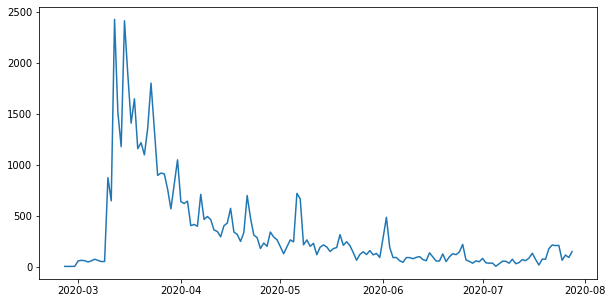

In [24]:
DATEFORMATDAY = "%Y%m%d"

x = [datetime.datetime.strptime(d,DATEFORMATDAY) for d in dates]
y = [dates[d] for d in dates]

plt.figure(figsize=(10,5))
plt.plot_date(x,y,fmt="-")
plt.show()